#Lliurament 3. Regressió

Aquesta és la tasca del tercer lliurament de Sistemes d'Aprenentatge Automàtic.

Aplicarem a unes mateixes dades tres mètodes de regressió: regressió lineal simple, regressió robusta amb RANSAC i regressió amb arbres.

Té setze apartats preguntes que puntuen tots igual: $0.625$ punts cadascun.

Preneu com a guia el següent **[quadern de regressió](https://colab.research.google.com/drive/1EBCxdZ-VD_xPzKIbuLg1NSZj74hKWXiw?usp=sharing)**.

##1. Preparació de les dades

a) Carregau el conjunt de dades Boston Housing.

b) Considerau $x$ el nombre de cambres i $y$ el preu de l'habitatge.

c) Representau la gràfica d'$y$ en funció de $x$ sense escalar.

d) Obteniu versions escalades de les variables $x$ i $y$, amb els noms $x\_std$ i $y\_std$.


In [8]:
# a) Cargar los datos del conjunto Boston Housing
import pandas as pd  # doctest: +SKIP
import numpy as np

data_url = "http://lib.stat.cmu.edu/datasets/boston"

df = pd.read_csv(data_url, sep="\s+", engine='python', skiprows=22, header=None)
print(df.size)

data=np.hstack([df.values[::2,0:11], df.values[1::2,0:3]])

columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PRATIO', 'B', 'LSTAT', 'MEDV']

df=pd.DataFrame(data,columns=columns)

df.head()

11132


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


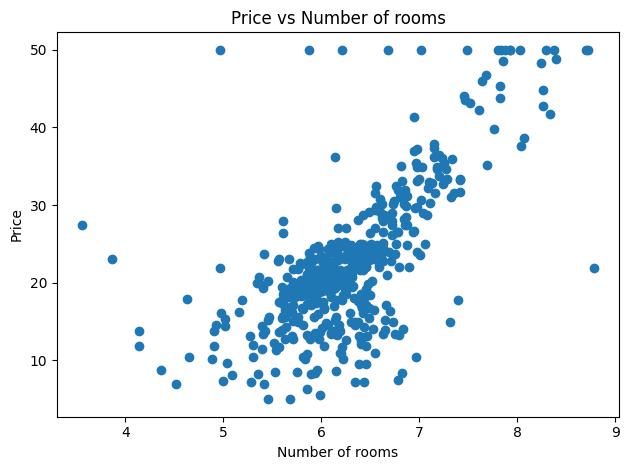

In [9]:
# b) Asignar valores a x (número de habitaciones) e y (precio de la vivienda)
x = df['RM']
y = df['MEDV']

# c) Representar gráficamente y en función de x sin escalar
import matplotlib.pyplot as plt

plt.scatter(x, y)
plt.xlabel('Number of rooms')
plt.ylabel('Price')
plt.title('Price vs Number of rooms')
plt.tight_layout()
plt.show()

# d) Obtener versiones escaladas de x e y
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_std = scaler.fit_transform(x.values.reshape(-1, 1))
y_std = scaler.fit_transform(y.values.reshape(-1, 1))

##2. Regressió lineal

a) Ajustau un predictor lineal a les variables d'entrada i sortida escalades.

b) Obteniu el valor de l'entrada escalada $x\_std$ quan $x=6$ cambres.

c) Amb el model de predicció, obteniu el valor de la sortida escalada $y\_std$.

d) Desescalau la sortida per obtenir el preu. Quin és el preu predit per a un habitatge de $6$ cambres? Contrastau el vostre resultat a la gràfica de l'apartat 1c, per confirmar que té sentit.

##3. RANSAC

Hi ha una sèrie de dades fora del núvol central. Per això és adequat usar un sistema de regressió robusta. Proposau valors del llindar per aconseguir diferents proporcions de punts com a *inliers*.

a) Obteniu tres llindars (*threshold*) diferents, que ajustin la recta a aproximadament una quarta part dels punts, la meitat dels punts i tres quartes parts dels punts.

b) Representau gràficament les tres situacions de l'apartat anterior.

c) Obteniu les tres prediccions del preu de l'habitatge de quatre cambres segons els tres models.

d) Comentau la diferència entre els tres resultats d'aquesta pregunta i comparau-los també amb el resultat de la pregunta anterior. Se semblen bastant les prediccions? Són molt diferents?

##4. Regressió amb arbres de decisió

a) Ajustau tres arbre de regressió a les mateixes dades que les preguntes anteriors, de forma que obtengueu infraajust, sobreajust i un bon ajust.

b) Representau les tres gràfiques dels models superposades al núvol de punts.

c) Quin és el preu predit per a un habitatge de 6 cambres amb el model de més bon ajust?

d) Comparau aquest resultat amb els dels models lineal simple i RANSAC.